## Feature (Engineering) Regressions using ML/DL Algorithms

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-09-12 10:23:06.430532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 10:23:06.454624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 10:23:06.488399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 10:23:06.498148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 10:23:06.523926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix,\
precision_score, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [3]:
trajl = 1
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [4]:
fovs = ['A2_2']
nfovs = len(fovs)
pathSet = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)

In [5]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [6]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells


In [7]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [8]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [9]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [10]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [11]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [12]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [13]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 97681, 99 tracks, 96000 left
tracked cell 97491, 26 tracks, 88600 left
tracked cell 97080, 1 tracks, 70500 left
tracked cell 97030, 1 tracks, 69600 left
tracked cell 96323, 1 tracks, 69200 left
tracked cell 95568, 1 tracks, 68800 left
tracked cell 94699, 1 tracks, 68200 left
tracked cell 94670, 3 tracks, 68100 left
tracked cell 94178, 1 tracks, 67300 left
tracked cell 92330, 2 tracks, 66100 left
tracked cell 92141, 5 tracks, 65900 left
tracked cell 92088, 1 tracks, 65800 left
tracked cell 91522, 1 tracks, 65600 left
tracked cell 90715, 1 tracks, 64800 left
tracked cell 89955, 19 tracks, 63900 left
tracked cell 88654, 1 tracks, 62700 left
tracked cell 88173, 2 tracks, 62600 left
tracked cell 87958, 1 tracks, 62400 left
tracked cell 87425, 36 tracks, 61900 left
tracked cell 86624, 1 tracks, 61200 left
tracked cell 86238, 1 tracks, 60900 left
tracked cell 83339, 1 tracks, 58900 left
tracked cell 83179, 1 tracks, 58800 left
tracked cell

## Load Cell Features & Labels Extracted from O2VAE (https://github.com/directysj/o2vae.git)

In [14]:
latent_dim=256
data_vae = np.load(f'../o2vae/features_vae{latent_dim}_{sysName[:-1]}{fovs[0]}.npz')
features_vae = data_vae['embeddings']
labels_vae = data_vae['labels']

In [15]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf_vae = features_vae[indsf, :]

In [16]:
for i in indgood_models:
    cell2cell_interaction_features = modelSet[i].Xf[:, 77:]
    modelSet[i].Xf_new = np.concatenate((modelSet[i].Xf_vae, cell2cell_interaction_features), axis=1)

In [17]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

## Single-cell Trajectories Over The Cell Features

In [18]:
#Xf_traj = np.zeros((0, (modelSet[0].Xf.shape[1]+n_COMfeatures)*trajl))
#Xf_traj = np.zeros((0, (modelSet[0].Xf_new.shape[1]+n_COMfeatures)*trajl))
Xf_traj = np.zeros((0, modelSet[0].Xf_vae.shape[1]*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf_vae[modelSet[i].traj, :] 
    #data = modelSet[i].Xf_new[modelSet[i].traj, :]
    #datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_vae.shape[1]*trajl)
    #data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_new.shape[1]*trajl)
    #datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    #data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0


In [19]:
def get_cellCycInfoTrajs(file_info):
    with open(file_info, 'r') as fp:
        lines = fp.readlines()

    nuc2cytoRatio = []
    CC_vals = []
    frames = []

    for line1, line2, line3 in zip(lines[::3], lines[1::3], lines[2::3]):
        line1 = np.array(line1.strip()[1:-1].split(', '), dtype=float)
        line2 = np.array(line2.strip()[1:-1].split(', '), dtype=float)
        line3 = np.array(line3.strip()[1:-1].split(', '), dtype=int)

        mask = ~np.isnan(line1)
        line1 = line1[mask]
        line2 = line2[mask]
        line3 = line3[mask]

        nuc2cytoRatio.append(line1)
        CC_vals.append(line2)
        frames.append(line3)

    return nuc2cytoRatio, CC_vals, frames

In [20]:
file_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/cellCycInfoRawReporterImgs/'
sname_reporter = "LI204601_G"

## Get Nuc/Cyto Ratios and CC values along all single-cell trajectories  

In [21]:
cc_filename = f"{file_path}{sname_reporter}_{fovs[0]}.dat"
n2c_ratio, cc_vals, frame_numbers = get_cellCycInfoTrajs(cc_filename)

In [22]:
valid_indstm = []
nuc2Cyto_ratio_last_frames = []
model_indc = 0
indstm = np.where(indtreatment_traj == model_indc)[0]
fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 

for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
    # Look for a snippet frame within its full trajectory
    possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])[0]
    if len(possible_indices) > 0:
        nbc_ratio = n2c_ratio[ind_fulltraj][possible_indices[0]]
        nuc2Cyto_ratio_last_frames.append(nbc_ratio)
        valid_indstm.append(indstm[j]) 

nuc2Cyto_ratio_last_frames = np.array(nuc2Cyto_ratio_last_frames)
X = Xf_traj[valid_indstm]  # Use the valid indices to index into Xf_traj
y = nuc2Cyto_ratio_last_frames

In [23]:
def trim_cc_vals(cc_values, num_bins, target_density):
    df = pd.DataFrame(cc_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

In [24]:
def unique_predictive_features(n_top_cont_features = 5):
    loadings = pca.components_
    feature_inds = np.array([]).astype(int)
    for i, pc in enumerate(loadings):
        # Gets indices of the top features for each PC
        top_features_indices = np.argsort(np.abs(pc))[-n_top_cont_features:] 
        #print(f"Top {n_cf} contributing feature indices for PC{i+1}: {top_features_indices}")
        feature_inds = np.append(feature_inds, top_features_indices)
    unique_feature_inds = np.unique(feature_inds)

    return unique_feature_inds

In [25]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape,\
Dense, Input, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE, ADASYN

In [27]:
scaler_nn = MinMaxScaler() # Scale features in the range [0, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
target_density = 1000; n_bins = 50
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]
X_train_nn = scaler_nn.fit_transform(X_train_trim)
X_test_nn = scaler_nn.transform(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

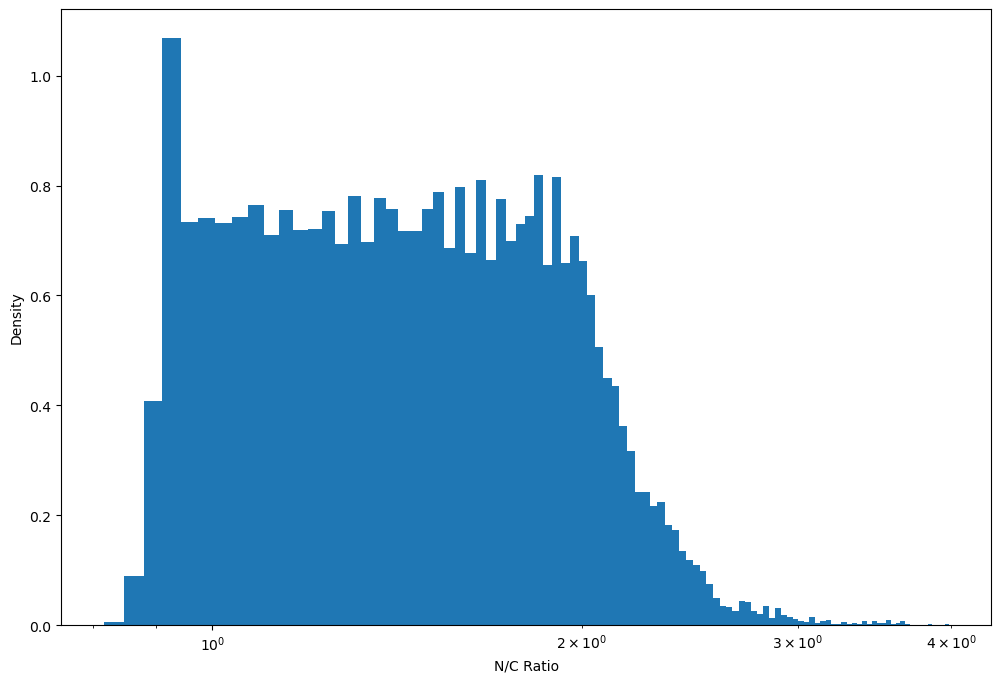

In [41]:
plt.clf()
fig, axs = plt.subplots(figsize = (12, 8))
axs.hist(y_train_trim, bins=100, density=True)
axs.set_xscale('log')
axs.set_xlabel('N/C Ratio')
axs.set_ylabel('Density')
#plt.savefig(f"./figs/distN2Cratio_{fovs[0]}_trajl{trajl}_VAE{latent_dim}.png", dpi=400, bbox_inches='tight')
plt.show

## Data Classification before Regression

In [29]:
def class_conditions(data, boundaries):
    conditions = []
    if len(boundaries) == 1:  # Special case for two classes
        conditions.append(data < boundaries[0])
        conditions.append(data >= boundaries[0])
    else:
        for i in range(len(boundaries) + 1):
            if i == 0:
                condition = data < boundaries[i]
            elif i == len(boundaries):
                condition = data >= boundaries[i-1]
            else:
                condition = (data >= boundaries[i-1]) & (data < boundaries[i])
            conditions.append(condition)
    return conditions

def multiclass_classification(data_train, data_test, boundaries):
    class_labels = list(range(len(boundaries) + 1))
    if len(boundaries) == 1:  # Special case for two classes
        class_labels = [0, 1]
    num_classes = len(class_labels)
    
    y_train_class = np.select(class_conditions(data_train, boundaries), class_labels)
    y_test_class = np.select(class_conditions(data_test, boundaries), class_labels)
    
    y_train_class_onehot = to_categorical(y_train_class)
    y_test_class_onehot = to_categorical(y_test_class)
    
    return y_train_class, y_test_class, y_train_class_onehot, y_test_class_onehot

In [30]:
#boundaries = [0.88, 2.7]  # For 3 classes
boundaries = [0.88] # For 2 classes
num_classes = int(len(boundaries) + 1)

y_train_class, y_test_class, y_train_class_onehot, y_test_class_onehot = multiclass_classification(y_train_trim, y_test, boundaries)

## Convolutional & Deep Neural Network Model Architecture

In [31]:
def create_model(input_shape, num_classes):
    
    inputs = Input(shape=input_shape) # Define the input layer
    x = Reshape((input_shape[0], 1, 1))(inputs) # Reshape input to fit Conv2D layer requirements

    ############################### First CNN layer #################################
    x = Conv2D(32, kernel_size=(3, 1), padding='same', kernel_regularizer=l2(0.01))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)

    ############################### Second CNN layer ################################
    x = Conv2D(64, kernel_size=(3, 1), padding='same', kernel_regularizer=l1(0.02))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x) # Flatten output of the last CNN layer

    ############################## First Dense layer ################################
    x = Dense(128, kernel_regularizer=l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    ############################# Second Dense layer ################################
    x = Dense(64, kernel_regularizer=l1(0.02))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x) # Output layer
    #######################@ Define model using "Model" API @########################
    model = Model(inputs=inputs, outputs=outputs) 
    
    return model

In [32]:
input_shape = (X_train_nn.shape[1], ) # Define input shape
# Create a Neural Network Model using the "Model" API from KERAS
model_nn = create_model(input_shape, num_classes) 

## Compile the model & Add early stopping to overcome potential overfitting 

In [33]:
model_nn.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               restore_best_weights=True,
                               patience=15,
                               min_delta=0.001) 

## Calculate class weights

In [34]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

## Oversample the minority class

In [35]:
over_sampler = RandomOverSampler(random_state=42, sampling_strategy='not majority')
#over_sampler = KMeansSMOTE(random_state=42, sampling_strategy='not majority')
#over_sampler = ADASYN(random_state=42, sampling_strategy='not majority')
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train_nn, y_train_class)

In [36]:
# Train the model with class weights and/or oversampling
#history_nn = model_nn.fit(X_train_nn, 
#                          to_categorical(y_train_class),
history_nn = model_nn.fit(X_train_resampled,
                          to_categorical(y_train_resampled),
                          epochs=50,
                          batch_size=25, 
                          validation_split=0.2,
                          #class_weight=class_weights_dict,
                          callbacks=[early_stopping])

Epoch 1/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8033 - loss: 7.8586 - val_accuracy: 0.9857 - val_loss: 0.4098
Epoch 2/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8482 - loss: 0.5154 - val_accuracy: 0.7947 - val_loss: 0.6595
Epoch 3/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8599 - loss: 0.4681 - val_accuracy: 1.0000 - val_loss: 0.3451
Epoch 4/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8718 - loss: 0.4473 - val_accuracy: 1.0000 - val_loss: 0.3610
Epoch 5/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8789 - loss: 0.4378 - val_accuracy: 0.9856 - val_loss: 0.4211
Epoch 6/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8815 - loss: 0.4236 - val_accuracy: 1.0000 - val_loss: 0.2911
Epoch 7/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8816 - loss: 0.4292 - val_accuracy: 0.9027 - val_loss: 0.5160
Epoch 8/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8834 -

## Predict on the test sets

In [37]:
y_pred_nn = model_nn.predict(X_test_nn)
predicted_classes = np.argmax(y_pred_nn, axis=1) # Get the predicted classes

################################# Calculate the prediction metrics #################################
accuracy = accuracy_score(y_test_class, predicted_classes)
precision = precision_score(y_test_class, predicted_classes, average="weighted", zero_division=np.nan)
recall = recall_score(y_test_class, predicted_classes, average="weighted")
f1 = f1_score(y_test_class, predicted_classes, average="weighted")

print(f"Accuracy: {accuracy * 100:.3f}%, Precision: {precision * 100:.3f}%, Recall: {recall * 100:.3f}%, F1-score: {f1 * 100:.3f}%")
"""
performance_data = {
    "Accuracy": f"{accuracy * 100:.3f}%",
    "Precision": f"{precision * 100:.3f}%",
    "Recall": f"{recall * 100:.3f}%",
    "F1-score": f"{f1 * 100:.3f}%"
}

with open(f"./jsonFiles/performanceNN_{fovs[0]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.json", 'w') as fout:
    json.dump(performance_data, fout, indent=4)
"""

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 75.189%, Precision: 99.877%, Recall: 75.189%, F1-score: 85.723%


'\nperformance_data = {\n    "Accuracy": f"{accuracy * 100:.3f}%",\n    "Precision": f"{precision * 100:.3f}%",\n    "Recall": f"{recall * 100:.3f}%",\n    "F1-score": f"{f1 * 100:.3f}%"\n}\n\nwith open(f"./jsonFiles/performanceNN_{fovs[0]}_trajl1_VAE{latent_dim}Cls{num_classes}.json", \'w\') as fout:\n    json.dump(performance_data, fout, indent=4)\n'

## Calculate and Visualize Confusion Matrix

In [38]:
class_labels = [i for i in range(num_classes)]
conf_matrix = confusion_matrix(y_test_class, predicted_classes, labels=class_labels, normalize='true')

<Figure size 640x480 with 0 Axes>

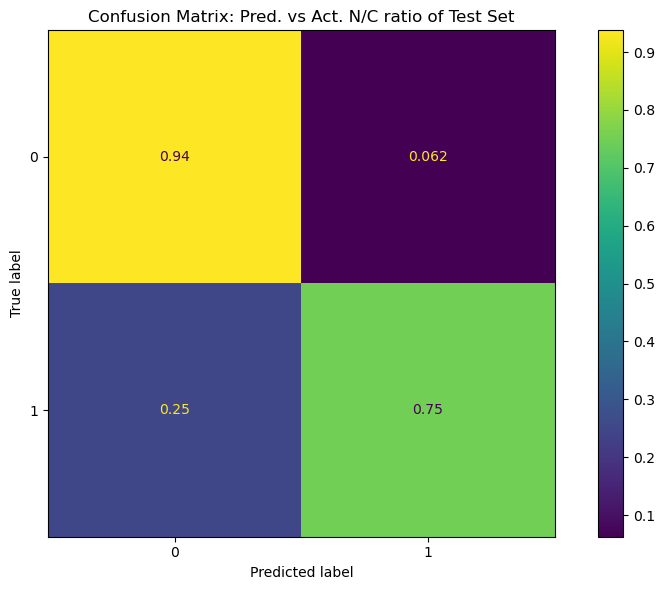

In [42]:
plt.clf()
fig, axs = plt.subplots(figsize=(9, 6))
disp_cm = ConfusionMatrixDisplay(conf_matrix)
disp_cm.plot(ax=axs)
plt.title('Confusion Matrix: Pred. vs Act. N/C ratio of Test Set')
plt.tight_layout()
plt.savefig(f"./figs/confMatrixNN_{fovs[0]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.png", dpi=400, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

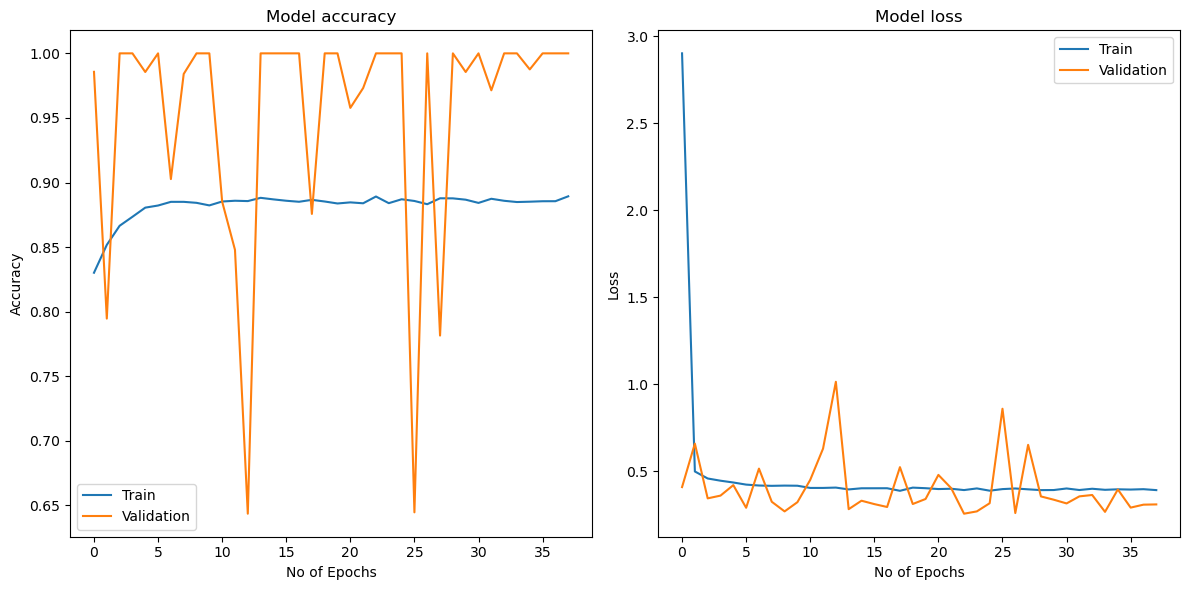

In [43]:
plt.clf()
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.savefig(f"./figs/performanceNN_{fovs[0]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.png", dpi=400, bbox_inches='tight')
plt.show()